In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import time
import os
import time
import pdb
import glob

# proxyの設定．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.autograd import Variable
from sklearn.svm import LinearSVC


### DCGAN
from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [53]:
# Root directory for dataset
dataroot = "ramen"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

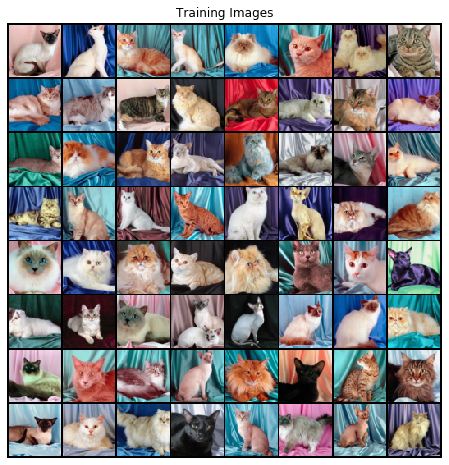

In [36]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [37]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [38]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [55]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [40]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [56]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [57]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [43]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/400][0/1]	Loss_D: 2.1187	Loss_G: 18.4617	D(x): 0.6045	D(G(z)): 0.6482 / 0.0000
[1/400][0/1]	Loss_D: 1.0400	Loss_G: 12.0575	D(x): 0.7836	D(G(z)): 0.2375 / 0.0000
[2/400][0/1]	Loss_D: 3.2062	Loss_G: 19.1805	D(x): 0.8728	D(G(z)): 0.9046 / 0.0000
[3/400][0/1]	Loss_D: 1.5775	Loss_G: 10.9300	D(x): 0.4681	D(G(z)): 0.0135 / 0.0001
[4/400][0/1]	Loss_D: 4.4135	Loss_G: 20.7930	D(x): 0.8710	D(G(z)): 0.9444 / 0.0000
[5/400][0/1]	Loss_D: 1.0888	Loss_G: 16.0246	D(x): 0.7511	D(G(z)): 0.0046 / 0.0000
[6/400][0/1]	Loss_D: 1.3127	Loss_G: 23.3768	D(x): 0.9546	D(G(z)): 0.5824 / 0.0000
[7/400][0/1]	Loss_D: 0.2783	Loss_G: 17.0867	D(x): 0.8294	D(G(z)): 0.0012 / 0.0000
[8/400][0/1]	Loss_D: 1.3044	Loss_G: 27.8081	D(x): 0.9245	D(G(z)): 0.5622 / 0.0000
[9/400][0/1]	Loss_D: 0.6296	Loss_G: 23.9620	D(x): 0.6323	D(G(z)): 0.0000 / 0.0000
[10/400][0/1]	Loss_D: 0.2228	Loss_G: 10.6698	D(x): 0.9209	D(G(z)): 0.0659 / 0.0001
[11/400][0/1]	Loss_D: 8.0687	Loss_G: 37.0787	D(x): 0.9772	D(G(z)): 0.99

[99/400][0/1]	Loss_D: 0.0002	Loss_G: 58.8240	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[100/400][0/1]	Loss_D: 0.0002	Loss_G: 58.9014	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[101/400][0/1]	Loss_D: 0.0002	Loss_G: 58.6861	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[102/400][0/1]	Loss_D: 0.0002	Loss_G: 58.8179	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[103/400][0/1]	Loss_D: 0.0002	Loss_G: 58.6038	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[104/400][0/1]	Loss_D: 0.0002	Loss_G: 58.7384	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[105/400][0/1]	Loss_D: 0.0002	Loss_G: 58.7850	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[106/400][0/1]	Loss_D: 0.0002	Loss_G: 58.7428	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[107/400][0/1]	Loss_D: 0.0002	Loss_G: 58.6104	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[108/400][0/1]	Loss_D: 0.0002	Loss_G: 58.6918	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[109/400][0/1]	Loss_D: 0.0002	Loss_G: 58.6389	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[110/400][0/1]	Loss_D: 0.0002	Loss_G: 58.6445	D(x): 0.9998	D(G(z)): 0.0000 / 

[197/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4740	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[198/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4214	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[199/400][0/1]	Loss_D: 0.0001	Loss_G: 58.5120	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[200/400][0/1]	Loss_D: 0.0001	Loss_G: 58.3025	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[201/400][0/1]	Loss_D: 0.0001	Loss_G: 58.5794	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[202/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4876	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[203/400][0/1]	Loss_D: 0.0001	Loss_G: 58.2456	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[204/400][0/1]	Loss_D: 0.0001	Loss_G: 58.3844	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[205/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4704	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[206/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4774	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[207/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4409	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[208/400][0/1]	Loss_D: 0.0001	Loss_G: 58.5755	D(x): 0.9999	D(G(z)): 0.0000 /

[295/400][0/1]	Loss_D: 0.0001	Loss_G: 58.5056	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[296/400][0/1]	Loss_D: 0.0001	Loss_G: 58.2225	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[297/400][0/1]	Loss_D: 0.0001	Loss_G: 58.1875	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[298/400][0/1]	Loss_D: 0.0001	Loss_G: 58.2332	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[299/400][0/1]	Loss_D: 0.0000	Loss_G: 58.4187	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[300/400][0/1]	Loss_D: 0.0000	Loss_G: 58.0761	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[301/400][0/1]	Loss_D: 0.0000	Loss_G: 58.3213	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[302/400][0/1]	Loss_D: 0.0000	Loss_G: 58.3985	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[303/400][0/1]	Loss_D: 0.0001	Loss_G: 58.4210	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[304/400][0/1]	Loss_D: 0.0001	Loss_G: 58.0849	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[305/400][0/1]	Loss_D: 0.0001	Loss_G: 58.3726	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[306/400][0/1]	Loss_D: 0.0000	Loss_G: 58.3433	D(x): 1.0000	D(G(z)): 0.0000 /

[393/400][0/1]	Loss_D: 0.0000	Loss_G: 58.1098	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[394/400][0/1]	Loss_D: 0.0000	Loss_G: 58.0772	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[395/400][0/1]	Loss_D: 0.0000	Loss_G: 58.0984	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[396/400][0/1]	Loss_D: 0.0000	Loss_G: 58.1196	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[397/400][0/1]	Loss_D: 0.0000	Loss_G: 58.2368	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[398/400][0/1]	Loss_D: 0.0000	Loss_G: 58.0790	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[399/400][0/1]	Loss_D: 0.0000	Loss_G: 58.0854	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


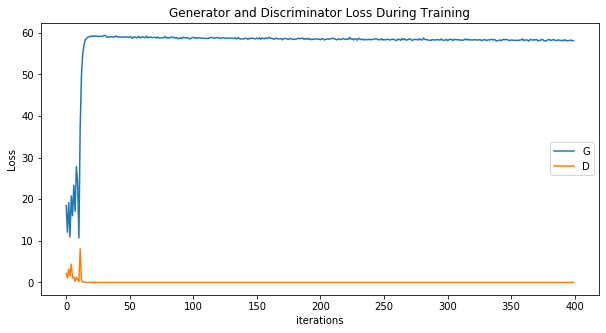

In [44]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

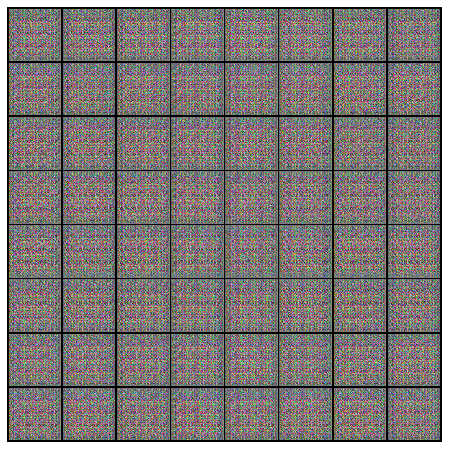

In [45]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

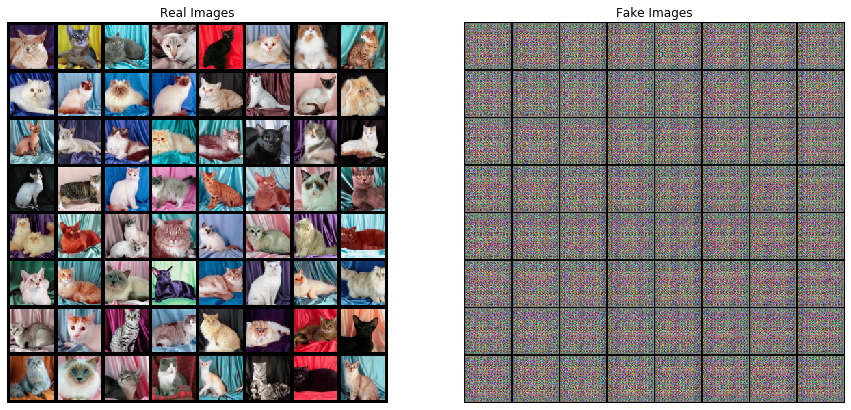

In [46]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

猫の差分が多かったのか、学習がうまくいかなかった。

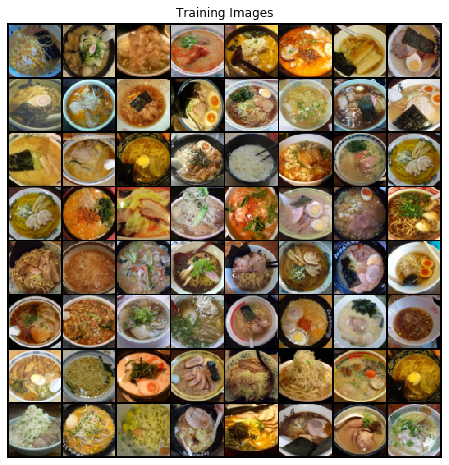

In [54]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [62]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/200][0/1]	Loss_D: 0.0004	Loss_G: 37.7484	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[1/200][0/1]	Loss_D: 0.0004	Loss_G: 37.8185	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[2/200][0/1]	Loss_D: 0.0004	Loss_G: 37.8015	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[3/200][0/1]	Loss_D: 0.0004	Loss_G: 37.6547	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[4/200][0/1]	Loss_D: 0.0004	Loss_G: 37.5996	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[5/200][0/1]	Loss_D: 0.0004	Loss_G: 37.6392	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[6/200][0/1]	Loss_D: 0.0004	Loss_G: 37.6315	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[7/200][0/1]	Loss_D: 0.0004	Loss_G: 37.6191	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[8/200][0/1]	Loss_D: 0.0004	Loss_G: 37.5211	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[9/200][0/1]	Loss_D: 0.0004	Loss_G: 37.5686	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[10/200][0/1]	Loss_D: 0.0004	Loss_G: 37.5365	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[11/200][0/1]	Loss_D: 0.0004	Loss_G: 37.5060	D(x): 0.9996	D(G(z)): 0.00

[99/200][0/1]	Loss_D: 0.0007	Loss_G: 38.6117	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[100/200][0/1]	Loss_D: 0.0007	Loss_G: 38.4882	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[101/200][0/1]	Loss_D: 0.0007	Loss_G: 38.5035	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[102/200][0/1]	Loss_D: 0.0007	Loss_G: 38.6516	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[103/200][0/1]	Loss_D: 0.0007	Loss_G: 38.4130	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[104/200][0/1]	Loss_D: 0.0006	Loss_G: 38.1839	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[105/200][0/1]	Loss_D: 0.0006	Loss_G: 38.3399	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[106/200][0/1]	Loss_D: 0.0007	Loss_G: 38.1648	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[107/200][0/1]	Loss_D: 0.0006	Loss_G: 38.1490	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[108/200][0/1]	Loss_D: 0.0006	Loss_G: 38.1193	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[109/200][0/1]	Loss_D: 0.0006	Loss_G: 38.1329	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[110/200][0/1]	Loss_D: 0.0007	Loss_G: 38.0944	D(x): 0.9993	D(G(z)): 0.0000 / 

[197/200][0/1]	Loss_D: 0.0002	Loss_G: 39.7155	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[198/200][0/1]	Loss_D: 0.0002	Loss_G: 39.7343	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[199/200][0/1]	Loss_D: 0.0002	Loss_G: 39.9499	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


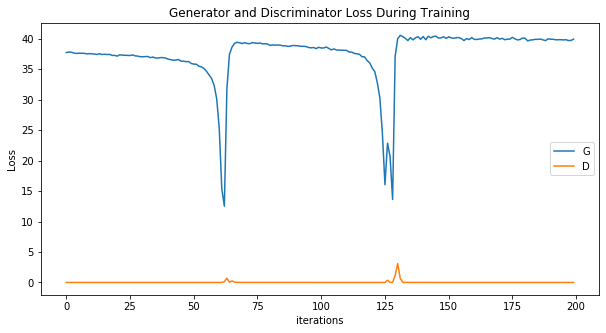

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

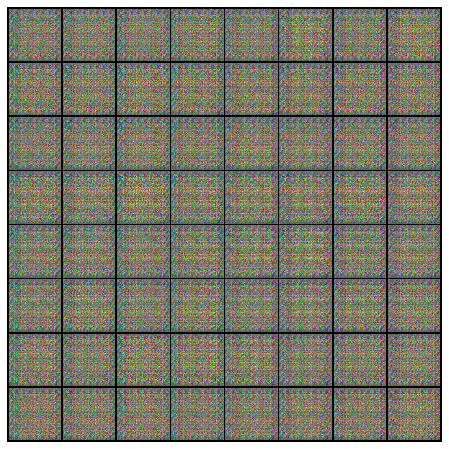

In [60]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSErro

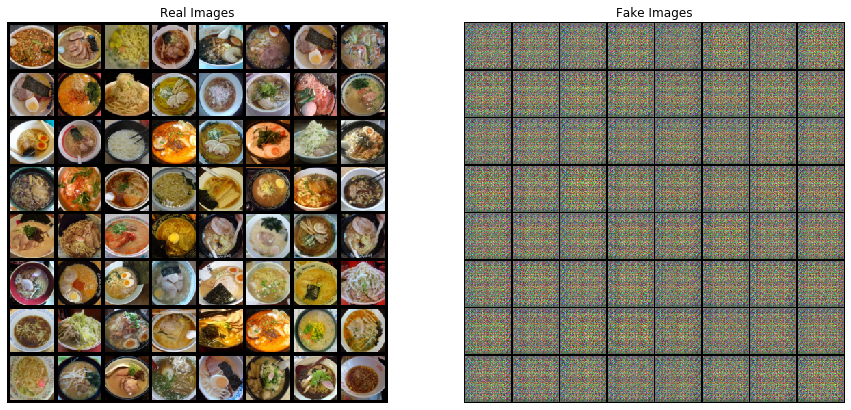

In [61]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

もっと単純そうなラーメン画像にしたが、黄色の特徴以外は出なかった。単純にデータ不足なのか、エポックを回すべきなのかわからない。ディスクリミネーターの学習が早すぎるので、そこら辺も影響しそう。あとは単純に損失関数をバイナリクロスエントロピー損失関数から別のGANの損失関数に変更するといいのかもしれない。時間がある時にもう一度挑戦したい。